# Data Analysis

In this notebook I am performing data analysis on the scraped data.

### Table of contents

1. [Libraries and dataset](#Libraries-and-dataset)

2. [Initial Data Exploration](#Initial-Data-Exploration)
  1. [Plotting the categorical data](#Plotting-the-categorical-data)
  2. [Plotting word frequencies](#Plotting-word-frequencies)
  
3. [Data Preprocessing](#Data-Preprocessing)
  1. [Convert all text to lower case](#Convert-all-text-to-lower-case)
  2. [Remove special characters, unnecessary punctuation and digits](#Remove-special-characters,-unnecessary-punctuation-and-digits)
  3. [Tokenize and remove stop words](#Tokenize-and-remove-stop-words)
  4. [Lemmatize the description words](#Lemmatize-the-description-words)
  
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  1. [Wordcloud visualizations](#Wordcloud-visualizations)
  2. [Visualizing n-gram distributions](#Visualizing-n-gram-distributions)
  
5. [Feature Engineering](#Feature-Engineering)

## Libraries and dataset

In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd                # Data processing
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
%matplotlib inline
sns.set_theme()

Let's load our database.

In [3]:
from modeling.database import MongoDB
db = MongoDB()

## Initial Data Exploration

Firstly, let's retrieve all documents. Then delete the id and url columns as well as
modify the roles column to only show the first role available instead of a list.

In [4]:
documents = db.get_all_documents()
df = pd.DataFrame(list(documents))

df = df.drop(df.columns[range(0,3)], axis=1)
df['roles'] = df['roles'].apply(lambda x: x[0] if isinstance(x, list) else x)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          35 non-null     object        
 1   roles          35 non-null     object        
 2   company        35 non-null     object        
 3   location       35 non-null     object        
 4   type           35 non-null     object        
 5   company_size   35 non-null     object        
 6   industry       34 non-null     object        
 7   workplace      29 non-null     object        
 8   published      35 non-null     object        
 9   description    35 non-null     object        
 10  date_inserted  35 non-null     datetime64[ns]
 11  level          16 non-null     object        
dtypes: datetime64[ns](1), object(11)
memory usage: 3.4+ KB


Let's check if our data contains null or NaN values.

In [5]:
df.head()

,title,roles,company,location,type,company_size,industry,workplace,published,description,date_inserted,level
0,Data Scientist/ AI Developer,Data Scientist,Incelligent,"Nea Smyrni, Attiki, Greece",Full-time,11-50,Telecommunications,On-site,2 weeks ago,We are looking for a bright Machine Learning E...,2022-11-27 13:31:33.086,NaN
1,Machine Learning Engineer,ML Engineer,Gaspardesk,"Athens, Attiki, Greece",Full-time,11-50,Software Development,On-site,1 month ago,We are looking for a Machine Learning (ML) Eng...,2022-11-27 13:31:37.809,NaN
2,Data Scientist,Data Scientist,Intracom Telecom,"Paiania, Attiki, Greece",Full-time,"1,001-5,000",Telecommunications,On-site,1 month ago,INTRACOM TELECOM is a global telecommunication...,2022-11-27 13:31:42.351,NaN
3,Data Scientist,Data Scientist,efood,"Athens, Attiki, Greece",Entry level,"1,001-5,000","Technology, Information and Internet",NaN,3 days ago,We are in the unique position to experience ne...,2022-11-27 13:31:47.247,NaN
4,Lead Data Scientist,Data Scientist,MarineTraffic,"Athens, Attiki, Greece",Full-time,51-200,IT Services and IT Consulting,Remote,2 weeks ago,We are a growing group of 190+ talented people...,2022-11-27 13:31:51.619,NaN


In [6]:
df.isnull().sum()

title             0
roles             0
company           0
location          0
type              0
company_size      0
industry          1
workplace         6
published         0
description       0
date_inserted     0
level            19
dtype: int64

### Plotting the categorical data

Let's begin by checkout out the distribution in the category columns of **roles** and **industry**.

In [7]:
df_role_count = df['roles'].value_counts()
df_role_count

Data Scientist    23
AI Engineer        7
ML Engineer        4
MLOps              1
Name: roles, dtype: int64

<AxesSubplot: >

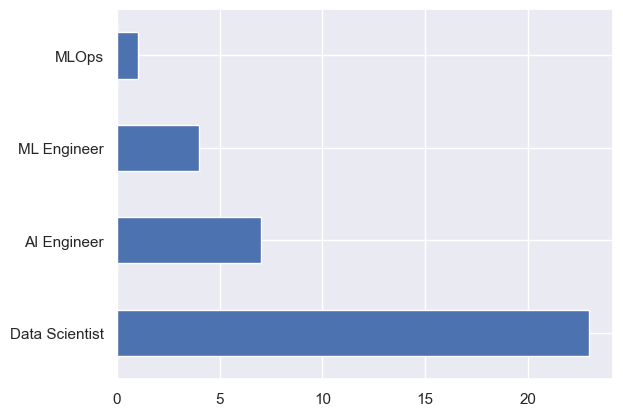

In [8]:
df_role_count.plot.barh()

In [9]:
df_industry_count = df['industry'].value_counts()
df_industry_count

IT Services and IT Consulting           9
Telecommunications                      6
Software Development                    6
Technology, Information and Internet    3
Accounting                              2
Financial Services                      2
Manufacturing                           1
Maritime Transportation                 1
Market Research                         1
Retail                                  1
Oil and Gas                             1
Staffing and Recruiting                 1
Name: industry, dtype: int64

<AxesSubplot: >

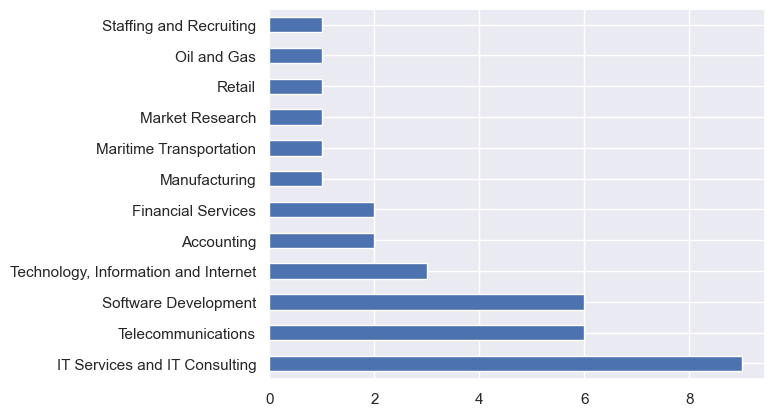

In [10]:
df_industry_count.plot.barh()

Next we will see the columns describing the workplace and the level.

Notice that the level category has the most null values, which we will probably drop later on.

In [11]:
df_work_count = df['workplace'].value_counts()
df_work_count

On-site    15
Remote      8
Hybrid      6
Name: workplace, dtype: int64

In [12]:
df_level_count = df['level'].value_counts()
df_level_count

Entry level         8
Mid-Senior level    5
Associate           2
Executive           1
Name: level, dtype: int64

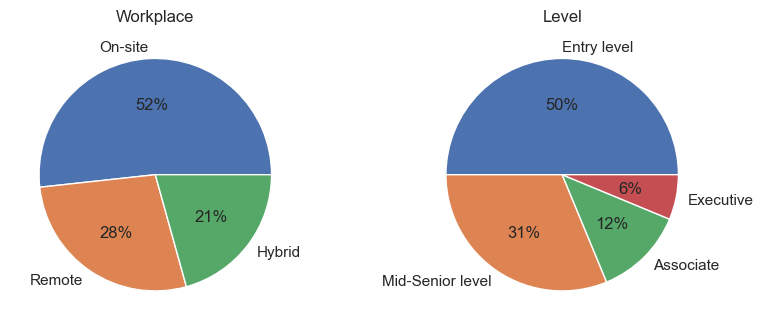

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
plt.subplots_adjust(wspace=0.4)

axes[0].pie(df_work_count, labels=df_work_count.index, autopct='%.0f%%')
axes[0].set_title("Workplace")

axes[1].pie(df_level_count, labels=df_level_count.index, autopct='%.0f%%')
axes[1].set_title("Level")

plt.show()

### Plotting word frequencies

Let's check out the 20 most common words in the role category.

In [14]:
from collections import Counter
ds_ct    = Counter(" ".join(df[df['roles']=='Data Scientist']["description"]).split()).most_common(20)
ai_ct    = Counter(" ".join(df[df['roles']=='AI Engineer']["description"]).split()).most_common(20)
ml_ct    = Counter(" ".join(df[df['roles']=='ML Engineer']["description"]).split()).most_common(20)
mlops_ct = Counter(" ".join(df[df['roles']=='MLOps']["description"]).split()).most_common(20)

In [15]:
df_ds = pd.DataFrame.from_dict(ds_ct)
df_ds = df_ds.rename(columns={0: "word", 1 : "count"})

df_ai = pd.DataFrame.from_dict(ai_ct)
df_ai = df_ai.rename(columns={0: "word", 1 : "count"})

df_ml = pd.DataFrame.from_dict(ml_ct)
df_ml = df_ml.rename(columns={0: "word", 1 : "count"})

df_mlops = pd.DataFrame.from_dict(mlops_ct)
df_mlops = df_mlops.rename(columns={0: "word", 1 : "count"})

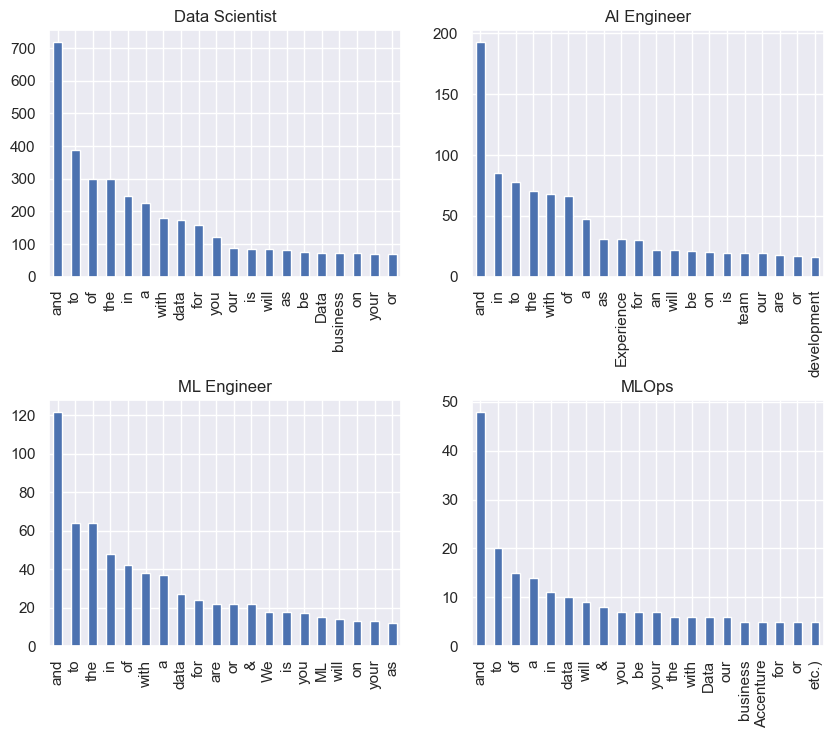

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)

df_ds.plot.bar(x='word', y='count', legend=False, ax=axes[0,0])
axes[0,0].set_title('Data Scientist')
axes[0,0].set(xlabel=None)

df_ai.plot.bar(x='word', y='count', legend=False, ax=axes[0,1])
axes[0,1].set_title('AI Engineer')
axes[0,1].set(xlabel=None)

df_ml.plot.bar(x='word', y='count', legend=False, ax=axes[1,0])
axes[1,0].set_title('ML Engineer')
axes[1,0].set(xlabel=None)

df_mlops.plot.bar(x='word', y='count', legend=False, ax=axes[1,1])
axes[1,1].set_title('MLOps')
axes[1,1].set(xlabel=None)

plt.show()

As we can see, the most common words are either propositions, conjuctions or pronouns.

Some entries are also not words but symbols or punctuation.

Later we will try to eliminate those as they should have no influence on the training of our model.

## Data Preprocessing

This part, called *data preprocessing*, is where we perform various transformations to the raw dataset's fields.

In detail, we will:

1. Convert all text to lower case
2. Remove special characters, unnecessary punctuation and digits
3. Tokenize sentences
4. Remove stop words
5. Lemmatize the description words

### Convert all text to lower case

In [17]:
df['description'] = df['description'].apply(lambda x: x.lower())
df['description'].head()

0    we are looking for a bright machine learning e...
1    we are looking for a machine learning (ml) eng...
2    intracom telecom is a global telecommunication...
3    we are in the unique position to experience ne...
4    we are a growing group of 190+ talented people...
Name: description, dtype: object

### Remove special characters, unnecessary punctuation and digits

In [18]:
df['description'] = df['description'].str.replace(r'[^\w\s]', ' ', regex=True)
df['description'].head()

0    we are looking for a bright machine learning e...
1    we are looking for a machine learning  ml  eng...
2    intracom telecom is a global telecommunication...
3    we are in the unique position to experience ne...
4    we are a growing group of 190  talented people...
Name: description, dtype: object

In [19]:
df['description'] = df['description'].str.replace(r'\d+', '', regex=True)
df['description'].head()

0    we are looking for a bright machine learning e...
1    we are looking for a machine learning  ml  eng...
2    intracom telecom is a global telecommunication...
3    we are in the unique position to experience ne...
4    we are a growing group of   talented people  s...
Name: description, dtype: object

### Tokenize sentences

In [20]:
from nltk.tokenize import word_tokenize

df['description'] = df['description'].apply(lambda x: word_tokenize(x))
df['description'].head()

0    [we, are, looking, for, a, bright, machine, le...
1    [we, are, looking, for, a, machine, learning, ...
2    [intracom, telecom, is, a, global, telecommuni...
3    [we, are, in, the, unique, position, to, exper...
4    [we, are, a, growing, group, of, talented, peo...
Name: description, dtype: object

### POS Tagging

In [21]:
#nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

word_pos = df['description'].apply(lambda x: pos_tag(x))
word_pos.head()

0    [(we, PRP), (are, VBP), (looking, VBG), (for, ...
1    [(we, PRP), (are, VBP), (looking, VBG), (for, ...
2    [(intracom, NN), (telecom, NN), (is, VBZ), (a,...
3    [(we, PRP), (are, VBP), (in, IN), (the, DT), (...
4    [(we, PRP), (are, VBP), (a, DT), (growing, VBG...
Name: description, dtype: object

### Remove stop words

In [22]:
#nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['description'] = df['description'].apply(lambda x: [word for word in x if word[0] not in stop_words])
df['description'].head()

0    [we, looking, for, bright, learning, engineer,...
1    [we, looking, for, learning, engineer, help, u...
2    [global, vendor, for, company, wireless, field...
3    [we, unique, position, experience, new, compan...
4    [we, growing, group, people, continents, unite...
Name: description, dtype: object

### Lemmatize the description words

In [23]:
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
df['description'] = df['description'].apply(lambda x: [wordnet_lemmatizer.lemmatize(word) for word in x])
df['description'].head()

0    [we, looking, for, bright, learning, engineer,...
1    [we, looking, for, learning, engineer, help, u...
2    [global, vendor, for, company, wireless, field...
3    [we, unique, position, experience, new, compan...
4    [we, growing, group, people, continent, united...
Name: description, dtype: object

## Exploratory Data Analysis

### Wordcloud visualizations

We are going to use the wordcloud package to visualize and show the most common tokens in each role.

First, let's check the unique roles we can find in the preprocessed dataset and then append all tokens to each respective role.

In [24]:
# Keep only the relevant columns
df = df[["roles", "description"]]

# Append description tokens to a single list based on it's respective role
role_descs = df.groupby(["roles"]).sum().reset_index()
role_list = role_descs['roles'].unique().tolist()
role_descs.head()

,roles,description
0,AI Engineer,"[wing, for, r, engineer, be, component, for, c..."
1,Data Scientist,"[we, looking, for, bright, learning, engineer,..."
2,ML Engineer,"[we, looking, for, learning, engineer, help, u..."
3,MLOps,"[ready, be, part, reinvention, revolutionize, ..."


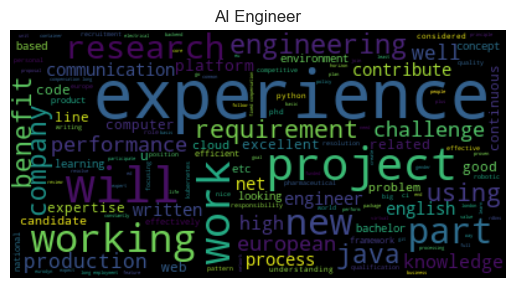

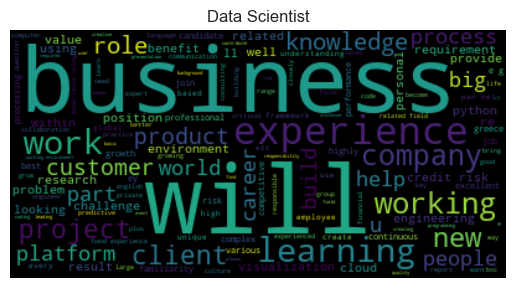

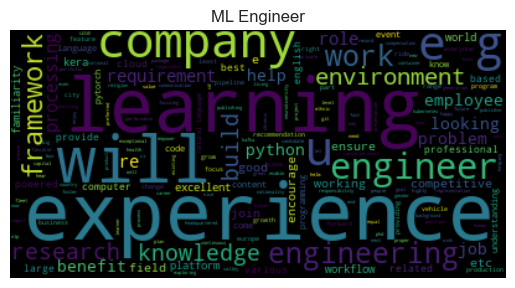

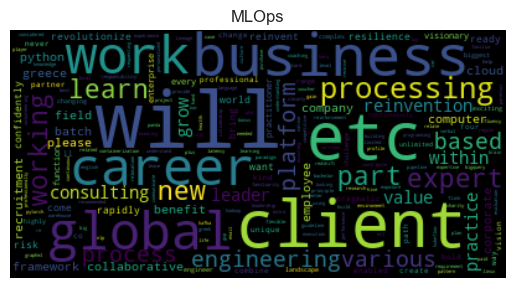

In [25]:
from wordcloud import WordCloud

for role in role_list:
    # Get the description tokens for each role
    tokens = role_descs[role_descs['roles'] == role].iloc[0].description

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate_from_text(' '.join(tokens))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(role)
    plt.show()

### Visualizing n-gram distributions

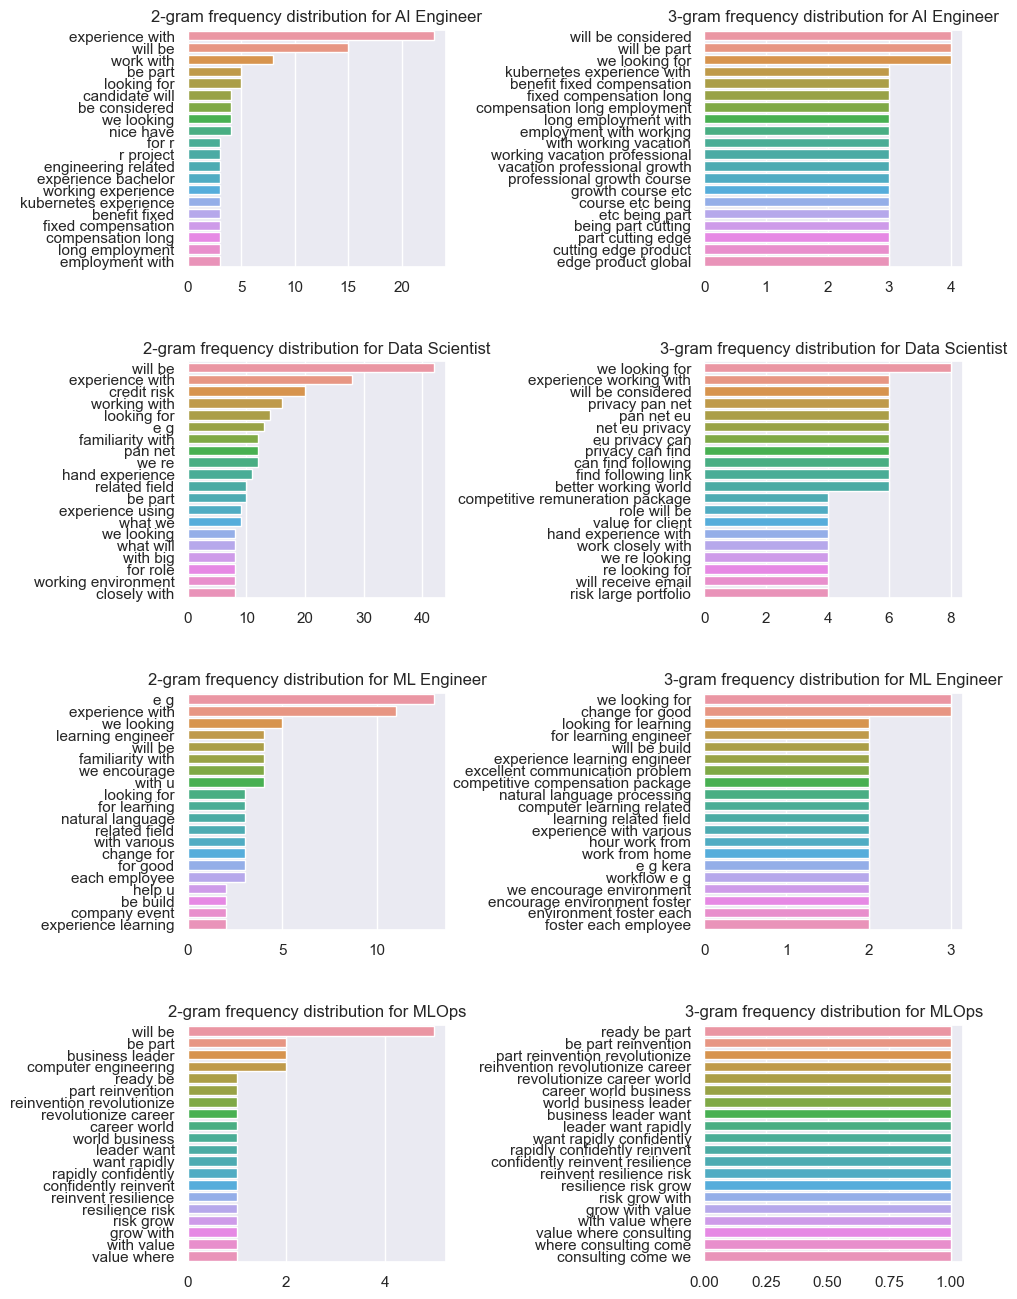

In [26]:
from nltk import FreqDist
from nltk.util import ngrams  

fig, axes = plt.subplots(4, 2, figsize=(10, 16))
plt.subplots_adjust(wspace=1, hspace=0.4)

index = 0
for role in role_list:
    tokens = role_descs[role_descs['roles'] == role].iloc[0].description

    bi_grams = ngrams(tokens, 2)
    tri_grams = ngrams(tokens, 3)
    
    bi_gram_dist = FreqDist(bi_grams).most_common(20)
    tri_gram_dist = FreqDist(tri_grams).most_common(20)

    ## Join bigram tokens with '_' + maintain sorting
    bi_gram_joined = {' '.join(k):v for k,v in sorted(bi_gram_dist, key=lambda item:item[1], reverse=True)}
    tri_gram_joined = {' '.join(k):v for k,v in sorted(tri_gram_dist, key=lambda item:item[1], reverse=True)}

    ## Convert to Pandas series for easy plotting
    bi_gram_freqdist = pd.Series(bi_gram_joined)
    tri_gram_freqdist = pd.Series(tri_gram_joined)
    
    ## Plotting
    bp1 = sns.barplot(x=bi_gram_freqdist.values, y=bi_gram_freqdist.index, orient='h', ax=axes[index, 0])
    axes[index,0].set_title(f'2-gram frequency distribution for {role}')
    
    bp2 = sns.barplot(x=tri_gram_freqdist.values, y=tri_gram_freqdist.index, orient='h', ax=axes[index, 1])
    axes[index,1].set_title(f'3-gram frequency distribution for {role}')
    
    index += 1
    
plt.show()

## Feature Engineering

As we can see from both the cloudword images and the n-gram distributions, there are still some words that we can safely remove as they provide no meaning for any role. Some of these could be the name of the company, or short words like "e.g".

Let's put them manually in another set of stop words.